In [1]:
from face_swap import warp_image_3d, mask_from_points, apply_mask, correct_colours

In [2]:
import os
from time import time

import cv2
import dlib
from skimage import io
import numpy as np

# import face_alignment


In [3]:
import face_alignment

In [4]:
image = io.imread('kekface/trololo_face.jpg')
io.imshow(image)

In [5]:
from main import Meme
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cuda')

In [6]:
memas = Meme('memes/trololo_face.json')

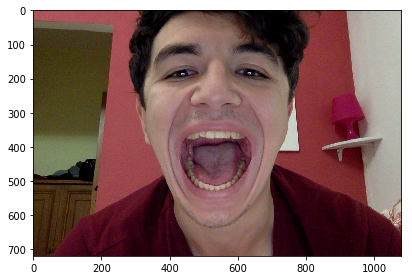

In [10]:
grisha = io.imread('open_mouth.jpg')[:, ::-1, :]
io.imshow(grisha)

In [11]:
res = memas.swap_face(grisha, fa)

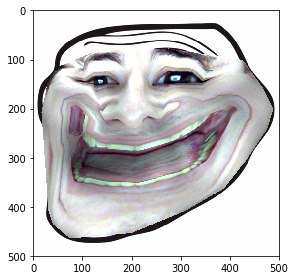

In [12]:
io.imshow(res)

In [31]:
mask = io.imread('trololo_mask.png')[...,0]
kernel = np.ones((3,3), dtype=np.uint8)
mask = cv2.erode(mask, kernel)[...,None] // 255

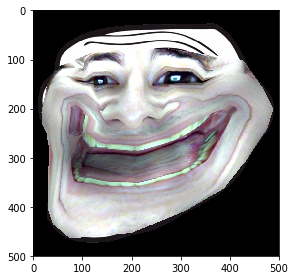

In [32]:
io.imshow(res*mask[...])

In [37]:
norm_grisha = io.imread('grisha_norm.jpg')
preds = fa.get_landmarks(norm_grisha)
preds = tuple((int(x), int(y)) for x, y in preds[0])
left, top = np.min(preds, 0)
right, bottom = np.max(preds, 0)
center = (top+bottom) // 2,(left+right)//2
h = 250
w = 250

face = norm_grisha[center[0]-h-100:center[0]+h-100, center[1]-w:center[1]+w]
face = face * (1-mask) + res * mask

norm_grisha[center[0]-h-100:center[0]+h-100, center[1]-w:center[1]+w] = face

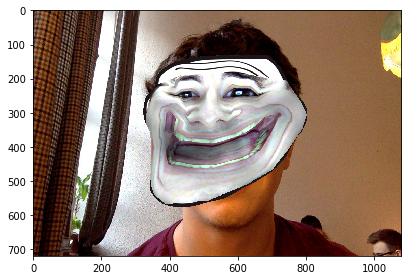

In [38]:
io.imshow(norm_grisha)

In [ ]:
norm_grisha[center-h:center+h, center-w:center+w][]

In [20]:
p = [tuple(point) for point in memas.points]

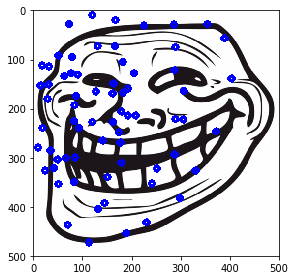

In [16]:
io.imshow(draw_landmarks(memas.img, [(p[1], p[0]) for p in memas.points]))

In [44]:
preds = fa.get_landmarks(grisha)
preds = tuple((int(x), int(y)) for x, y in preds[0])

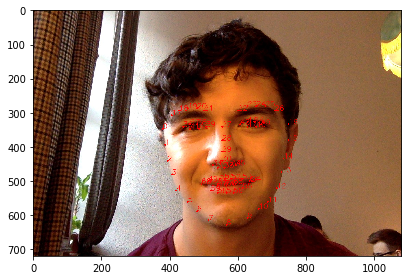

In [35]:
io.imshow(draw_landmarks(grisha, preds))

In [ ]:
# cuda for CUDA
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cuda')

In [7]:
preds = fa.get_landmarks(image)
preds = tuple((int(x), int(y)) for x, y in preds[0])

In [9]:
%timeit fa.get_landmarks(image)

58.3 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
import cv2
def draw_landmarks(image, landmarks):
    image = image.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, point in enumerate(landmarks):
        cv2.circle(image, tuple(point), 1, (0, 0, 0), thickness=2)
        cv2.putText(image,'{}'.format(i), tuple(point), font, 0.5, (0,0,0),1,cv2.LINE_AA)
    return image

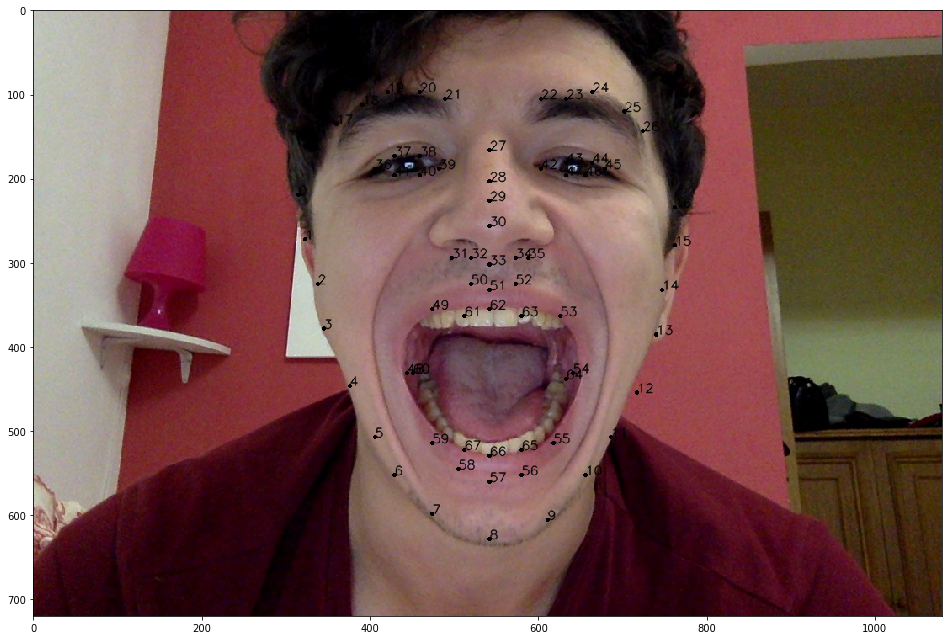

In [45]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))
io.imshow(draw_landmarks(grisha, preds))

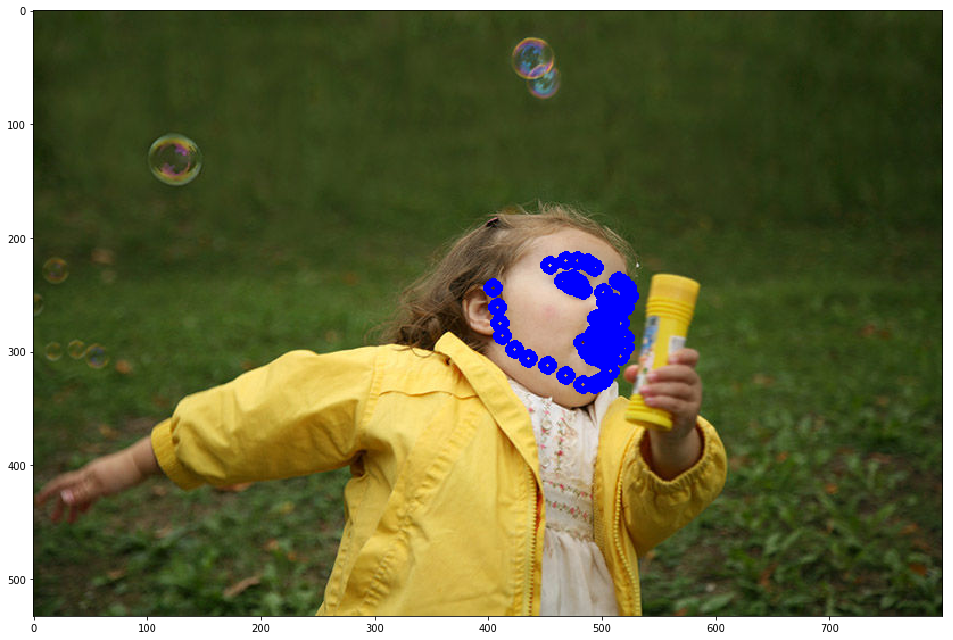

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))
io.imshow(draw_landmarks(image, preds))

In [10]:
import json

In [90]:
meme_girl = {'name': 'swift_girl', 'landmarks': preds, 'path': 'kekface/girl.jpg', 'method': 'fa_2d', 'version': 3}

In [91]:
with open('memes/girl.json', 'w') as f:
    f.write(json.dumps(meme_girl))

In [11]:
with open('memes/girl.json', 'r') as f:
    a = json.loads(f.read())

In [ ]:



def select_face(im, detector, predictor, r=10):
#     fx = max(im.shape)
#     fx = int(fx / 200 + 0.5)

#     kek_img = cv2.resize(cv2.GaussianBlur(im, (fx + (1-fx % 2), fx + (1-fx % 2)), 0),
#                          (0, 0), fx=1/fx, fy=1/fx, interpolation=cv2.INTER_NEAREST)
#     faces = face_detection(kek_img, detector)
#     areas = [face.area() for face in faces]
#     bbox = faces[np.argmax(areas)]

#     bbox = dlib.rectangle(bbox.left()*fx, bbox.top()*fx, bbox.right()*fx, bbox.bottom()*fx)

#     points = np.asarray(face_points_detection(im, bbox, predictor))
    points = fa.get_landmarks(im)[0]
    if points is None:
        return None, None, None

    im_w, im_h = im.shape[:2]
    left, top = np.min(points, 0)
    right, bottom = np.max(points, 0)

    x, y = max(0, left-r), max(0, top-r)
    w, h = min(right+r, im_h)-x, min(bottom+r, im_w)-y

    return points - np.asarray([[x, y]]), (x, y, w, h), im[y:y+h, x:x+w]


class Meme():
    def __init__(self, json_path, detector, predictor, fx=3):
        with open(json_path, 'r') as f:
            meme_cfg = json.loads(f.read())
        self.img = cv2.imread(meme_cfg['path'])
        self.points = np.array(meme_cfg['landmarks'])
        self.points, self.shape, self.face = self.extract_face()
        self.w, self.h = self.face.shape[:2]
        
    def extract_face(self, r=10):
        im_w, im_h = self.img.shape[:2]
        left, top = np.min(self.points, 0)
        right, bottom = np.max(self.points, 0)

        x, y = max(0, left - r), max(0, top - r)
        w, h = min(right + r, im_h) - x, min(bottom + r, im_w) - y

        return self.points - np.asarray([[x, y]]), (x, y, w, h), self.img[y:y+h, x:x+w]

    def swap_face(self, source_image):
        try:
            src_points, src_shape, src_face = select_face(source_image, detector, predictor)
            if src_points is None:
                return self.img
            start = time()
            warped_src_face = warp_image_3d(src_face, src_points[:], self.points[:], (self.w, self.h))
            # Mask for blending
            mask = mask_from_points((self.w, self.h), self.points)
            mask_src = np.mean(warped_src_face, axis=2) > 0
            mask = np.asarray(mask*mask_src, dtype=np.uint8)
            # Correct color
            warped_src_face = apply_mask(warped_src_face, mask)
            dst_face_masked = apply_mask(self.face, mask)
            warped_src_face = correct_colours(dst_face_masked, warped_src_face, self.points)
            # Poisson Blending
            bounding_rect = cv2.boundingRect(mask)
            center = ((bounding_rect[0] + int(bounding_rect[2] / 2),
                       bounding_rect[1] + int(bounding_rect[3] / 2)))

            # output = cv2.seamlessClone(warped_src_face, self.face, mask, center, cv2.NORMAL_CLONE)

            mask = mask[..., None] // 255

            output = warped_src_face * mask + self.face * (1 - mask)
            # cv2.imshow('mask', output)
            # print(mask.max())

            x, y, w, h = self.shape
            result = self.img.copy()
            result[y:y+h, x:x+w] = output

            return result
        except:
            return self.img


In [ ]:
meme = Meme('memes/girl.jpg')

In [22]:
import cv2
cap = cv2.VideoCapture('movie.mov')
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
w, h = int(cap.get(3)), int(cap.get(4))
writer = cv2.VideoWriter('output.mov', fourcc, 12.0, (w,h))
lens = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    preds = fa.get_landmarks(frame)
    if preds is None:
        writer.write(frame)
        continue
    lens.append(len(preds[0]))
    preds = tuple((int(x), int(y)) for x, y in preds[0])
    frame = draw_landmarks(frame, preds)
    writer.write(frame)
    
writer.release()
cap.release()
    

In [23]:
import numpy as np
np.unique(lens)

array([68])

In [24]:
image = io.imread()

AttributeError: 'NoneType' object has no attribute 'dtype'